In [1]:
from math import sqrt
import alpaca_trade_api as tradeapi
from datetime import datetime
import pytz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import json
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA


# API credentials
api_key = 'AKQB26E5HLHLA54FOT9T'
api_secret = 'hNgAGISeVTThSFOoa1biaGcRuWYD8HvOvtb1AB7c'
base_url = 'https://paper-api.alpaca.markets'  

# Initialize the Alpaca API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

symbol = 'SPY' 
start_date = datetime(2023, 1, 1).astimezone(pytz.timezone('UTC')) 
end_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC'))  


daily_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, start_date.isoformat(), end_date.isoformat()).df
print(daily_prices)

#  ******************* ADDING SENITMENT DATA *******************

with open('temp.json', 'r') as file:
    sentiment_data = json.load(file)

sentiment_df = pd.DataFrame(list(sentiment_data.items()), columns=['date', 'sentiment'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.tz_localize('UTC')


daily_prices.index = pd.to_datetime(daily_prices.index, utc=True)

combined_df = pd.merge(daily_prices, sentiment_df, how='inner', left_index=True, right_on='date')

print(combined_df.head())



In [ ]:
X = daily_prices[['close', 'high', 'low', 'trade_count', 'open']]
X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100
X['open_close_percent'] = (X['open'] - X['close']) / X['close'] * 100

X = X.drop('open', axis=1)
X = X.drop('close', axis=1)
X = X.drop('high', axis=1)
X = X.drop('low', axis=1)


# normalized data 
avg_vol = daily_prices['volume'].sum() / daily_prices.shape[0]

Y = daily_prices['volume'] / avg_vol


C:\Users\amirt\AppData\Local\Temp\ipykernel_22200\2626257824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100


c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


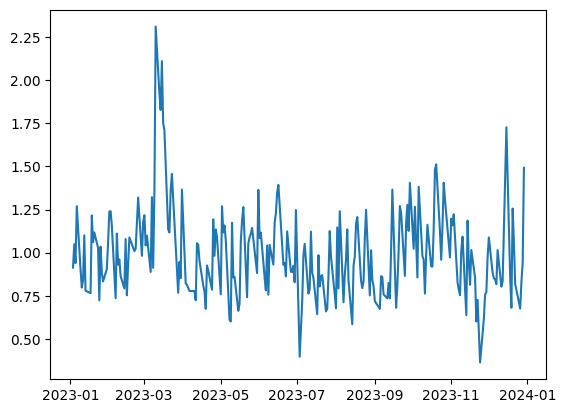

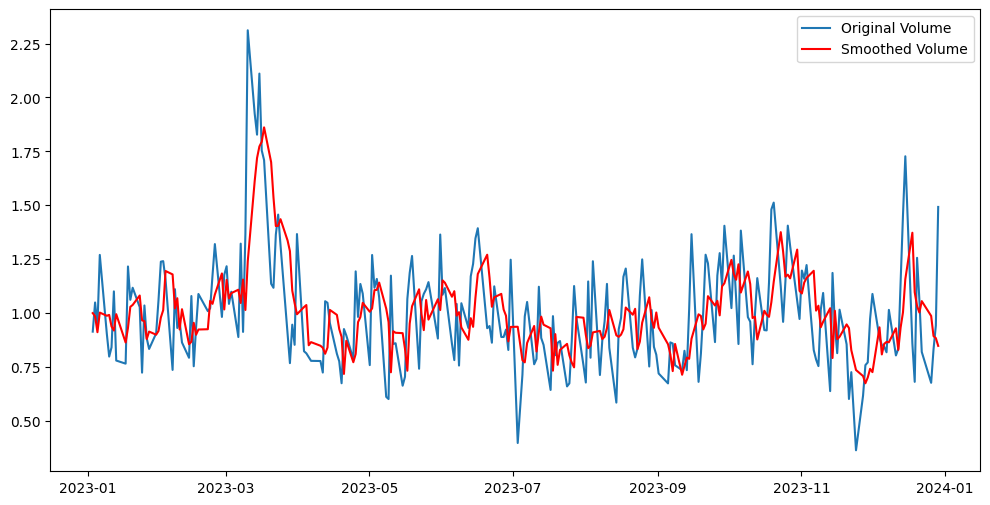

In [ ]:
# Exponential Smoothing
model = ExponentialSmoothing(Y, trend="add", seasonal="add", seasonal_periods=12)
fitted_model = model.fit()

plt.plot(Y)
plt.show()

# Plot original data and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='Original Volume')
plt.plot(Y.index, fitted_model.fittedvalues, label='Smoothed Volume', color='red')
plt.legend()
plt.show()

y_smooth = fitted_model.fittedvalues

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [ ]:
# DECISION TREE MODEL

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.013921899494770023
R-squared: 0.8397067634925317


In [ ]:
# XGB BOOST MODEL

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.013067503180643356
R-squared: 0.8495440669799519


Mean Squared Error: 0.01178855676137576
R-squared: 0.8642695332096898


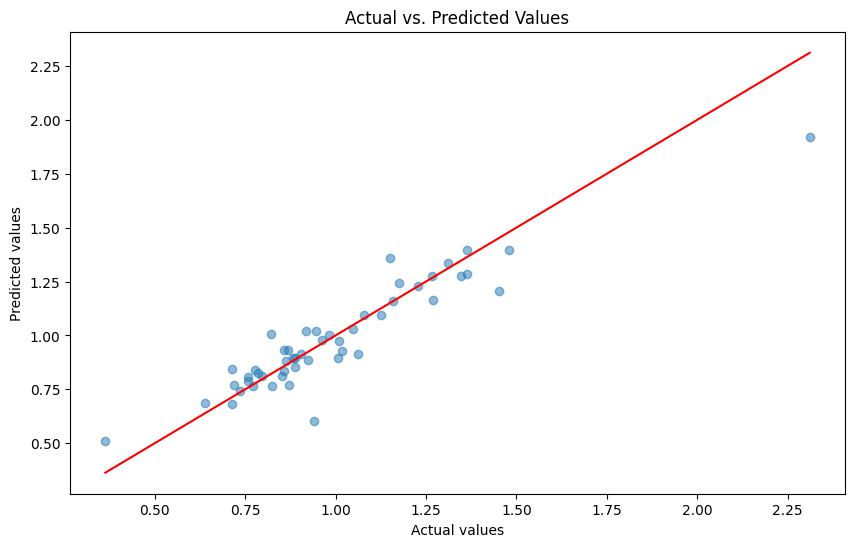

In [ ]:
# FOREST MODEL

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

Epoch 1/100


c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9432797184.0000 - val_loss: 5229984256.0000
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3895588608.0000 - val_loss: 1719713152.0000
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1194451712.0000 - val_loss: 352071616.0000
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 216597488.0000 - val_loss: 24563538.0000
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11321591.0000 - val_loss: 540456.1250
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1194279.5000 - val_loss: 1991959.2500
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1443154.3750 - val_loss: 319901.5000
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163681.4219 - val_loss: 260.0370
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4771.7407 - val_loss: 13545.9346
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9783.0068 - val_loss: 1653.6761
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━

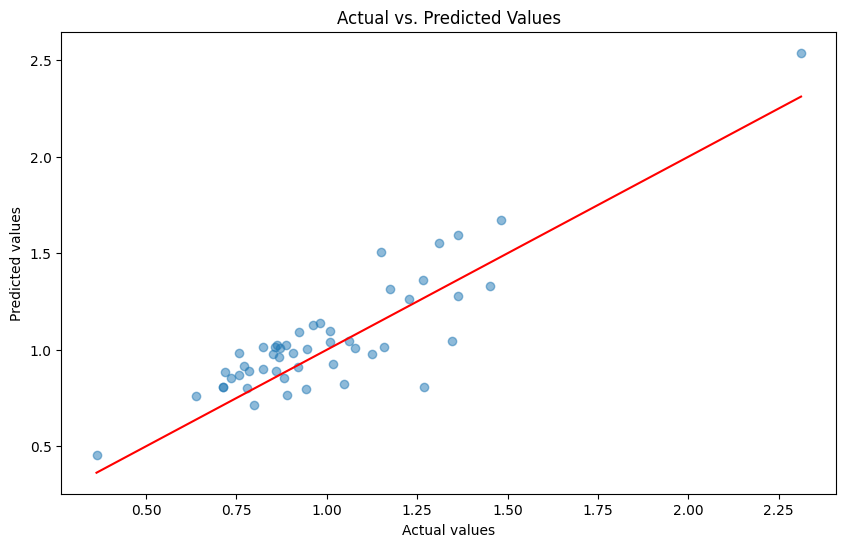

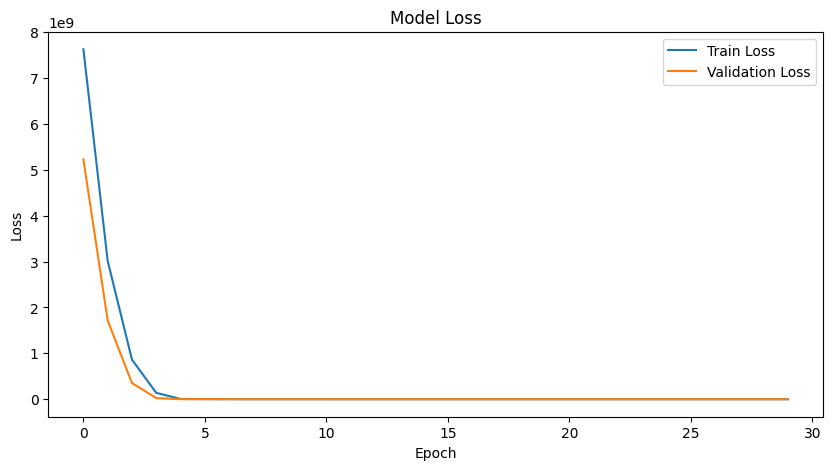

" # TRYING TO DO THIS FOR TODAY TO SEE ACCURACY\n\nformatted_end_date = end_date.strftime('%Y-%m-%d')\nformatted_start_date = start_date.strftime('%Y-%m-%d')\nstart_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC')) \nend_date = datetime(2024, 3, 1).astimezone(pytz.timezone('UTC'))  \n\nmodel_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, formatted_start_date, formatted_end_date).df\nmodel_prices['high_low_percent'] = (model_prices['high'] - model_prices['low']) / model_prices['low'] * 100\nmodel_prices['open_close_percent'] = (model_prices['open'] - model_prices['close']) / model_prices['close'] * 100\n\n# Keep only the necessary columns for the model input\nmodel_prices_predict = model_prices[['high_low_percent', 'open_close_percent', 'trade_count']]\n\n# Keep the date and volume for reference\nreference_data = model_prices[['date', 'volume']]\n\n# Predict using the model\npredictions = model.predict(model_prices_predict)\npredictions = predictions.flatten()  # Flatt

In [ ]:
# NEURAL NETWORK
import numpy as np
import random
from tensorflow import random as tf_random


model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)), 
    Dense(10, activation='relu'),
    Dense(1) 
])

np.random.seed(42)
random.seed(42)
tf_random.set_seed(42)

# Include callbacks for consistency in training performance
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions.flatten())
r2 = r2_score(y_test, predictions.flatten())

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Ensure this part is applicable only if you're tracking accuracy for a classification problem
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()


""" # TRYING TO DO THIS FOR TODAY TO SEE ACCURACY

formatted_end_date = end_date.strftime('%Y-%m-%d')
formatted_start_date = start_date.strftime('%Y-%m-%d')
start_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC')) 
end_date = datetime(2024, 3, 1).astimezone(pytz.timezone('UTC'))  

model_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, formatted_start_date, formatted_end_date).df
model_prices['high_low_percent'] = (model_prices['high'] - model_prices['low']) / model_prices['low'] * 100
model_prices['open_close_percent'] = (model_prices['open'] - model_prices['close']) / model_prices['close'] * 100

# Keep only the necessary columns for the model input
model_prices_predict = model_prices[['high_low_percent', 'open_close_percent', 'trade_count']]

# Keep the date and volume for reference
reference_data = model_prices[['date', 'volume']]

# Predict using the model
predictions = model.predict(model_prices_predict)
predictions = predictions.flatten()  # Flatten the predictions if necessary

# Combine predictions with reference data
reference_data['predictions'] = predictions

# Print or save the combined data
print(reference_data) """


In [ ]:
# # ARIMA

# model = ARIMA(daily_prices['volume'], order=(1,1,1)) 
# results = model.fit()
# print(results.summary())

# #print plot of this results variable vs the original data


In [ ]:
# DECISION TREE MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.1695125712795729
R-squared: -0.22216198992809155


In [ ]:
# XGB BOOST MODEL and SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.15363548579071118
R-squared: -0.003940617983233308


In [ ]:
# FOREST MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.14184234393990844
R-squared: 0.14427001852599053


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split

daily_prices = pd.read_csv('daily_prices.csv')
X = daily_prices[['close', 'high', 'low', 'trade_count', 'open']]
X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100
X['open_close_percent'] = (X['open'] - X['close']) / X['close'] * 100

X = X.drop('open', axis=1)
X = X.drop('close', axis=1)
X = X.drop('high', axis=1)
X = X.drop('low', axis=1)


# normalized data 
avg_vol = daily_prices['volume'].sum() / daily_prices.shape[0]

Y = daily_prices['volume'] / avg_vol

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

#might need to zip the x and the y into one variable to pass them in 
# Combine X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)
print(train_data.columns.tolist())


# train_data.index = pd.to_datetime(train_data[''], utc=True)

# print(train_data)

# endog = train_data['volume']
endog = train_data['trade_count']
# exog = train_data['volume']


#order (first two is the number of past data points to look at (maybe increase to 5), third is the past encountered error variable, the second is for reduction in variability (ie kinda smoothing))
ARIMAModel = ARIMA(endog=endog, order=(2, 2, 2), seasonal_order=(1, 1, 1, 12))

results = ARIMAModel.fit()
print(results.summary())


test_data_combined = pd.concat([X_test, y_test], axis=1)


# y_pred = ARIMAModel.get_forecast(len(test_data_combined['trade_count'].index))
# y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df = ARIMAModel.predict(test_data_combined['trade count'])
# y_pred_df.index = test_data_combined['trade_count'].index
# y_pred_out = y_pred_df["Predictions"] 
print(y_pred_def)

/var/folders/8c/c_w4247x7t3g1w488pg529fc0000gq/T/ipykernel_81520/2435308397.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100
/var/folders/8c/c_w4247x7t3g1w488pg529fc0000gq/T/ipykernel_81520/2435308397.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['open_close_percent'] = (X['open'] - X['close']) / X['close'] * 100
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

['trade_count', 'high_low_percent', 'open_close_percent', 'volume']
                                     SARIMAX Results                                      
Dep. Variable:                        trade_count   No. Observations:                  200
Model:             ARIMA(2, 2, 2)x(1, 1, [1], 12)   Log Likelihood               -2536.764
Date:                            Wed, 08 May 2024   AIC                           5087.528
Time:                                    14:17:27   BIC                           5110.108
Sample:                                         0   HQIC                          5096.678
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1067      0.251     -0.426   

KeyError: 'trade count'

In [ ]:



test_data_combined = pd.concat([X_test, y_test], axis=1)
fig, ax = plt.subplots()
plt.plot(endog, color = "black", label="Train")
plt.plot(test_data_combined['trade count'], color = "red", label="Test")
plt.plot(y_pred_out, color='green', label = 'Predictions')
ax.fill_between(y_pred_out.index,y_pred_df['lower Close'], y_pred_df['upper Close'], color='b', alpha=.15)
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Stock Close")
plt.legend()
plt.show()

c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                  168
Model:              SARIMAX(2, 2, 12)   Log Likelihood               -3021.631
Date:                Thu, 16 May 2024   AIC                           6073.263
Time:                        23:48:38   BIC                           6119.943
Sample:                             0   HQIC                          6092.211
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7202      0.033    -51.908      0.000      -1.785      -1.655
ar.L2         -0.9980      0.033    -30.355      0.000      -1.062      -0.934
ma.L1          0.3173      0.557      0.570      0.5

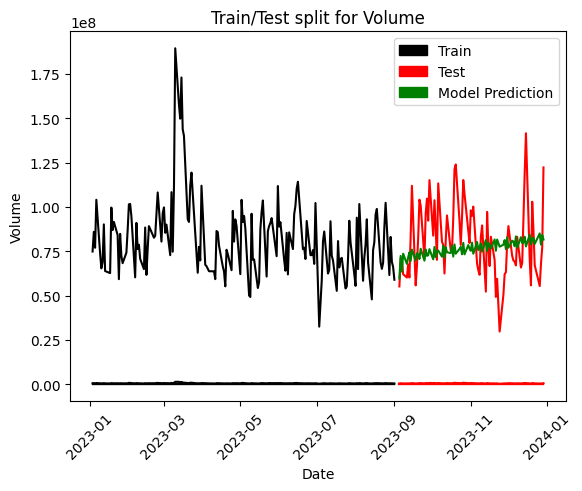

In [33]:
# polsley playing around with random code
import matplotlib.patches as mpatches 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split

daily_prices = pd.read_csv('daily_prices.csv')
X = daily_prices[['close', 'high', 'low', 'trade_count', 'open','volume']]
X.index = pd.to_datetime(daily_prices['timestamp'])

import datetime as dt
import pytz

import matplotlib.pyplot as plt

et = pytz.timezone('America/New_York')

train = X[X.index < dt.datetime(2023,9,1,tzinfo=et)]
test = X[X.index > dt.datetime(2023,9,1,tzinfo=et)]

endog = train['volume']
exog = train['high']

#order (first two is the number of past data points to look at (maybe increase to 5), third is the past encountered error variable, the second is for reduction in variability (ie kinda smoothing))
ARIMAmodel = SARIMAX(endog=endog, order=(2, 2, 12))

results = ARIMAmodel.fit()
print(results.summary())

test_endog = test['volume']
test_exog = test['high']

y_pred = results.get_forecast(len(test_endog.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

y_pred_df.columns = ['lower Close', 'upper Close', 'Predictions']


fig, ax = plt.subplots()
plt.plot(train, color = "black", label="Train")
plt.plot(test, color = "red", label="Test")
plt.plot(y_pred_out, color='green', label = 'Predictions')
# ax.fill_between(y_pred_out.index,y_pred_df['lower Close'], y_pred_df['upper Close'], color='b', alpha=.15)
plt.ylabel('Volume')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Volume")

trainLabel = mpatches.Patch(color='black', label='Train') 
testLabel = mpatches.Patch(color='red', label='Test') 
predictionLabel = mpatches.Patch(color='green', label='Model Prediction') 
plt.legend(handles=[trainLabel,testLabel,predictionLabel]) 
plt.show()

c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\amirt\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                  168
Model:              SARIMAX(2, 2, 12)   Log Likelihood               -3021.631
Date:                Thu, 16 May 2024   AIC                           6073.263
Time:                        23:02:51   BIC                           6119.943
Sample:                             0   HQIC                          6092.211
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7202      0.033    -51.908      0.000      -1.785      -1.655
ar.L2         -0.9980      0.033    -30.355      0.000      -1.062      -0.934
ma.L1          0.3173      0.557      0.570      0.5

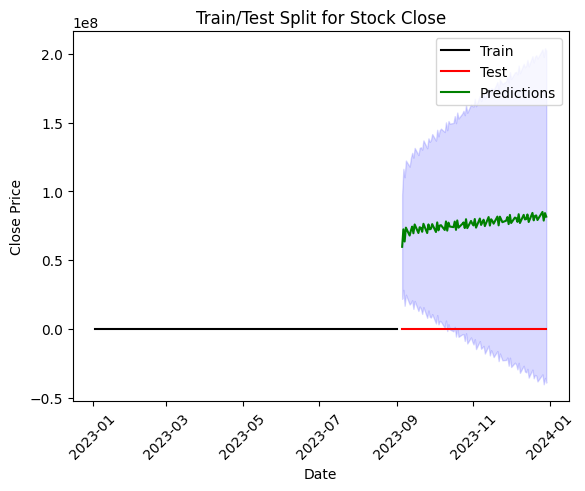

In [23]:
#this below is just me messing around with different ways of doing the same thing from above 

daily_prices = pd.read_csv('daily_prices.csv')

daily_prices['timestamp'] = pd.to_datetime(daily_prices['timestamp'])
daily_prices.set_index('timestamp', inplace=True)

X = daily_prices[['close', 'high', 'low', 'trade_count', 'open', 'volume']]

et = pytz.timezone('America/New_York')

train = X[X.index < dt.datetime(2023, 9, 1, tzinfo=et)]
test = X[X.index >= dt.datetime(2023, 9, 1, tzinfo=et)]


endog = train['volume']
exog = train['high']


ARIMAmodel = SARIMAX(endog=endog, order=(2, 2, 12))
results = ARIMAmodel.fit()
print(results.summary())


test_endog = test['volume']
test_exog = test['high']
y_pred = results.get_forecast(steps=len(test_endog))
y_pred_df = y_pred.conf_int(alpha=0.05)


y_pred_df["Predictions"] = y_pred.predicted_mean
y_pred_df.index = test.index


y_pred_df.columns = ['lower bound', 'upper bound', 'Predictions']


fig, ax = plt.subplots()
ax.plot(train.index, train['close'], color="black", label="Train")
ax.plot(test.index, test['close'], color="red", label="Test")
ax.plot(y_pred_df.index, y_pred_df['Predictions'], color='green', label='Predictions')
ax.fill_between(y_pred_df.index, y_pred_df['lower bound'], y_pred_df['upper bound'], color='blue', alpha=.15)


ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
ax.set_title("Train/Test Split for Stock Close")
plt.xticks(rotation=45)
ax.legend()
plt.show()